# 조건을 부여하여 생성모델 다루기
## - cGAN 및 Pix2Pix

## 조건 있는 생성 모델, cGAN
- Conditional Generative Adversarial Nets (cGAN)
- 내가 원하는 종류의 이미지를 생성할 수 있도록 고안된 방법.

### GAN의 목적함수
- GAN 구조는 Generator 및 Discriminator라 불리는 두 신경망이 minimax game을 통해 서로 경쟁하며 발전함.
- Generator는 이 식을 최소화하려, Discriminator는 이 식을 최대화하려 학습함.
- D의 입장에서는 진짜 데이터를 진짜로 가짜 데이터를 가짜로 정확히 예측하도록 학습해야 함. 
- G의 입장에서는 생성한 데이터를 D가 진짜 데이터라고 예측할 만큼 진짜 같은 가짜 데이터를 만들도록 학습함.

### cGAN의 목적함수
- GAN의 목적함수와 차이점은 D(x)와 G(z)가 각각 D(x∣y), G(z∣y)로 바뀐 것임.
- G와 DD의 입력에 특정 조건을 나타내는 정보인 yy를 같이 입력한다는 것.
- GAN의 목적함수와 동일하므로 각각 yy를 추가로 입력받아 GG의 입장에서 식을 최소화하고, DD의 입장에서 식을 최대화하도록 학습함.

In [1]:
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8 MB 9.8 kB/s  eta 0:00:01��█████████████▎              | 227.9 MB 75.8 MB/s eta 0:00:03
     |████████████████████████████████| 3.8 MB 65.7 MB/s eta 0:00:01
     |████████████████████████████████| 448 kB 39.5 MB/s eta 0:00:01
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7538 sha256=9d2af3f7f5623c1af9727a4de7f98660b081cbc07c941aead68310039e8bc178
  Stored in directory: /aiffel/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Attempting uninstall: gast
    Found existing installation: gast 0.3.

In [3]:
import tensorflow as tf

print(tf.__version__)

2.1.0


##  Generator 구성하기

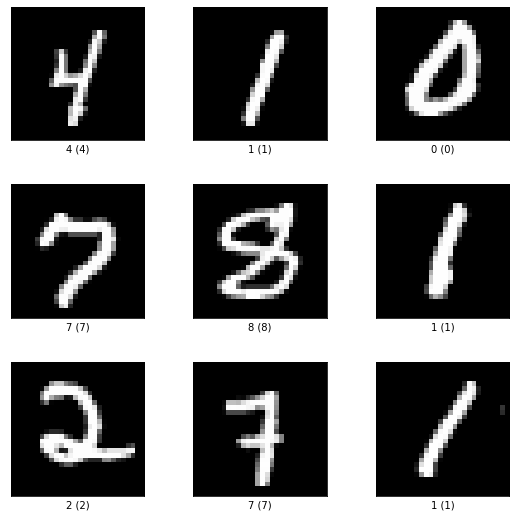

In [4]:
#tensorflow datasets에서 MNIST 데이터셋 로드
import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

In [2]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1   #이미지 픽셀 값을 -1~1 사이의 범위로 변경
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1   #이미지 픽셀 값을 -1~1 사이의 범위로 변경
    
    label = tf.one_hot(data["label"], 10)   #레이블 정보를 원-핫 인코딩(one-hot encoding)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)

Label : tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


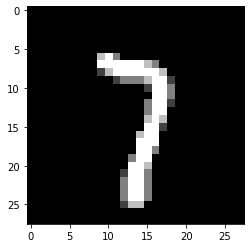

In [3]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

#이미지와 라벨이 일치하는지 확인
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

- 과 1로 이루어진 원-핫 벡터에는 각자 고유의 인덱스가 있음. 
- MNIST의 경우, 숫자 0은 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]의 인덱스 값을 가짐.
- 나는 7이 나왔으므로 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]의 값이 나온 것.

### Tensorflow2의 Subclassing 방법으로 GAN Generator 구성하기

In [4]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

print("✅")

✅


- call() 메서드에서는 노이즈를 입력받아 __init__()에서 정의된 레이어들을 순서대로 통과.
- 4개의 fully-connected 레이어 중 한 개를 제외하고 모두 ReLU 활성화를 사용.
- Generator는 숫자가 쓰인 이미지를 출력해야 하므로 마지막 출력은 layers.Reshape()을 이용해 (28,28,1) 크기로 변환.

### cGAN Gnerator 구성하기

In [5]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
    
print("✅")

✅


- GAN과의 구조적인 차이점인 레이블 정보가 추가된 것 뿐.
- cGAN의 입력은 2개(노이즈 및 레이블 정보).
- 노이즈 입력 및 레이블 입력은 각각 1개의 fully-connected 레이어와 ReLU 활성화를 통과.
- 다시 한번 1개의 fully-connected 레이어와 ReLU 활성화를 통과.
- 위의 결과가 1개의 fully-connected 레이어 및 Hyperbolic tangent 활성화를 거쳐 28x28 차원의 결과가 생성되고 (28,28,1) 크기의 이미지 형태로 변환되어 출력

## Discriminator 구성

### GAN Discriminator 구성하기

In [6]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x
    
print("✅")

✅


- __init__()에 blocks라는 리스트를 하나 만들어 놓고, for loop를 이용하여 필요한 레이어들을 차곡차곡 쌓는 방식을 사용하여 각각의 fully-connected 레이어를 매번 정의하지 않아도 됨.
- Discriminator의 입력은 Generator가 생성한 (28,28,1) 크기의 이미지임.
- 마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력됨.

### cGAN Discriminator 구성하기

In [7]:
#Maxout 구성하기

class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=1)

print("✅")

✅


- Maxout 레이어를 구성할 때 units과 pieces의 설정이 필요하며, units 차원 수를 가진 fully-connected 레이어를 pieces개 만큼 만들고 그 중 최대 값을 출력.

In [8]:
#Maxout 레이러를 3번 사용하여 cGAN의 Discriminator 구성
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅")

✅


## 학습 및 테스트

In [9]:
#GAN, cGAN 각각의 모델 학습에 공통적으로 필요한 loss function과 optimizer를 정의
#진짜 및 가짜를 구별하기 위해 Binary Cross Entropy를 사용하고, Adam optimizer를 이용해 학습

from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

print("✅")

✅


### GAN으로 MNIST 학습하기

In [10]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        #Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        #Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        #각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
        
    #gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    
    #모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    
    return gene_loss, disc_loss

print("✅")

✅


In [11]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:   #100번의 반복마다 각 손실을 출력
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:1.965017318725586, D:0.17737966775894165
[1/10 EPOCHS, 200 ITER] G:2.6541075706481934, D:0.11566486954689026
[1/10 EPOCHS, 300 ITER] G:2.7433059215545654, D:0.09104505926370621
[1/10 EPOCHS, 400 ITER] G:2.478959798812866, D:0.11490923911333084
[2/10 EPOCHS, 100 ITER] G:3.2178375720977783, D:0.44987019896507263
[2/10 EPOCHS, 200 ITER] G:3.4844932556152344, D:0.1617421805858612
[2/10 EPOCHS, 300 ITER] G:4.4912309646606445, D:0.11742647737264633
[2/10 EPOCHS, 400 ITER] G:2.6117734909057617, D:0.2620084583759308
[3/10 EPOCHS, 100 ITER] G:2.918658971786499, D:0.1514943242073059
[3/10 EPOCHS, 200 ITER] G:3.1953659057617188, D:0.0724853053689003
[3/10 EPOCHS, 300 ITER] G:3.8951401710510254, D:0.08793016523122787
[3/10 EPOCHS, 400 ITER] G:3.5281896591186523, D:0.09450934827327728
[4/10 EPOCHS, 100 ITER] G:4.1906046867370605, D:0.08871245384216309
[4/10 EPOCHS, 200 ITER] G:4.390322685241699, D:0.17647479474544525
[4/10 EPOCHS, 300 ITER] G:3.930351734161377, D:0.0833977

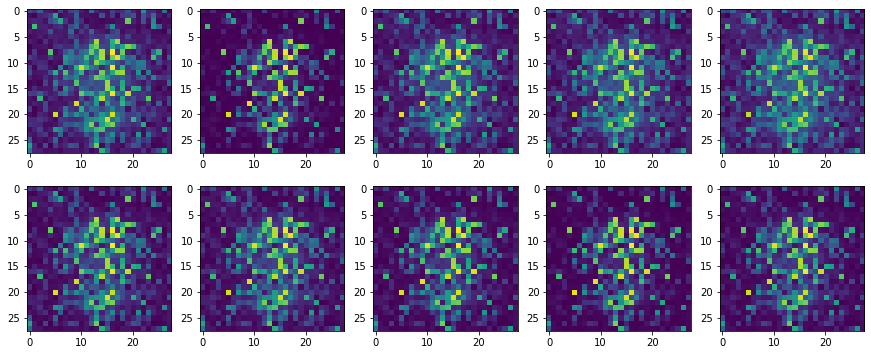

In [12]:
#100차원 노이즈 입력을 10개 사용하여 10개의 숫자 손글씨 데이터를 생성해 시각화

import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

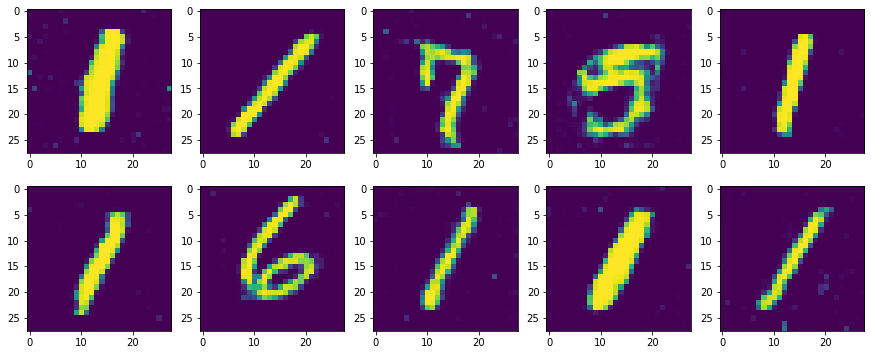

In [13]:
#500epoch 학습한 가중치 사용
import os
weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

- 내가 원하는 특정 숫자 하나를 출력하기 위해 수많은 입력을 넣어야 함.
- 원하는 숫자를 바로 얻기 위해  cGAN을 이용.

### cGAN으로 MNIST 학습하기

In [14]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:2.7650320529937744, D:0.10971184074878693
[1/1 EPOCHS, 199 ITER] G:4.071874618530273, D:0.031860075891017914
[1/1 EPOCHS, 299 ITER] G:3.681180715560913, D:0.14361535012722015
[1/1 EPOCHS, 399 ITER] G:3.4198994636535645, D:0.09913834184408188


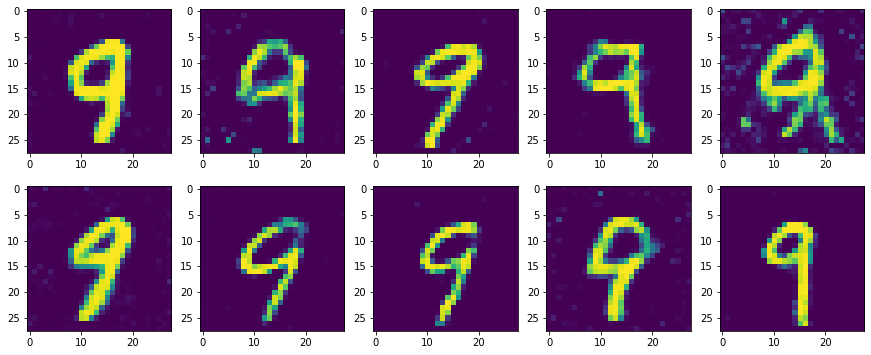

In [15]:
#충분한 학습이 되기엔 많은 시간을 투자해야 하므로 
#500epoch 학습한 가중치 사용.

#생성할 숫자 입력
number = 9

weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

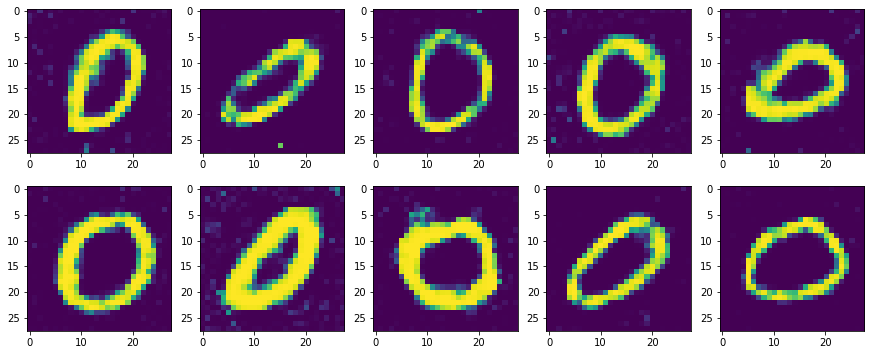

In [16]:
#생성할 숫자 입력
number = 0

weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

## Pix2Pix
- 이미지를 입력으로 하여 원하는 다른 형태의 이미지로 변환시킬 수 있는 GAN 모델.
- Conditional Adversarial Networks로 Image-to-Image Translation을 수행한다는 뜻.
- 이미지 변환이 목적인 Pix2Pix는 이미지를 다루는데 효율적인 convolution 레이어를 활용.
- GAN 구조를 기반으로 하기 때문에 크게 Generator와 Discriminator 두 가지 구성 요소로 이루어짐.

### Pix2Pix(Generator)
- Encoder에서 입력 이미지(x)를 받으면 단계적으로 이미지를 down-sampling 하면서 입력 이미지의 중요한 representation을 학습함.
- Decoder에서는 이를 이용해 반대로 다시 이미지를 up-sampling하여 입력 이미지와 동일한 크기의 변환된 이미지(y)를 생성함.
- 이러한 과정은 모두 convolution 레이어로 진행됨.

### Pix2Pix (Loss Function)
- Generator만을 사용한 이미지 변환은 출력된 이미지와 실제 이미지의 차이로 L2(MSE), L1(MAE) 같은 손실을 계산한 후 이를 역전파하여 네트워크를 학습시키면 됨.
- 하지만 Generator만으로 생성된 결과는 매우 흐릿함.
- Generator가 단순히 이미지의 평균적인 손실만을 줄이고자 파라미터를 학습하기 때문임.

### Pix2Pix (Discriminator)
- 실제 같은 이미지를 얻기 위해선 Generator를 발전시킬 서포터이자 경쟁자, Discriminator가 필요함.
- 하나의 이미지가 Discriminator의 입력으로 들어오면, convolution 레이어를 거쳐 확률값을 나타내는 최종 결과를 생성하고 그 결과는 하나의 값이 아닌 여러 개의 값을 가짐. 
- 전체 영역을 다 보는 것이 아닌 일부 영역(파란색 점선)에 대해서만 진짜/가짜를 판별하는 하나의 확률값을 도출한다는 것.
-  서로 다른 영역에 대해 진짜/가짜를 나타내는 여러 개의 확률값을 계산할 수 있으며 이 값을 평균하여 최종 Discriminator의 출력을 생성.
- 이러한 방법은 이미지의 일부 영역(patch)을 이용한다고 하여 PatchGAN이라고 불림.
- 일반적으로 이미지에서 거리가 먼 두 픽셀은 서로 연관성이 거의 없기 때문에 특정 크기를 가진 일부 영역에 대해서 세부적으로 진짜/가짜를 판별하는 것이 Generator로 하여금 더 진짜 같은 이미지를 만들도록 하는 방법임.

## 채색 실습

### - 데이터 준비

In [5]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


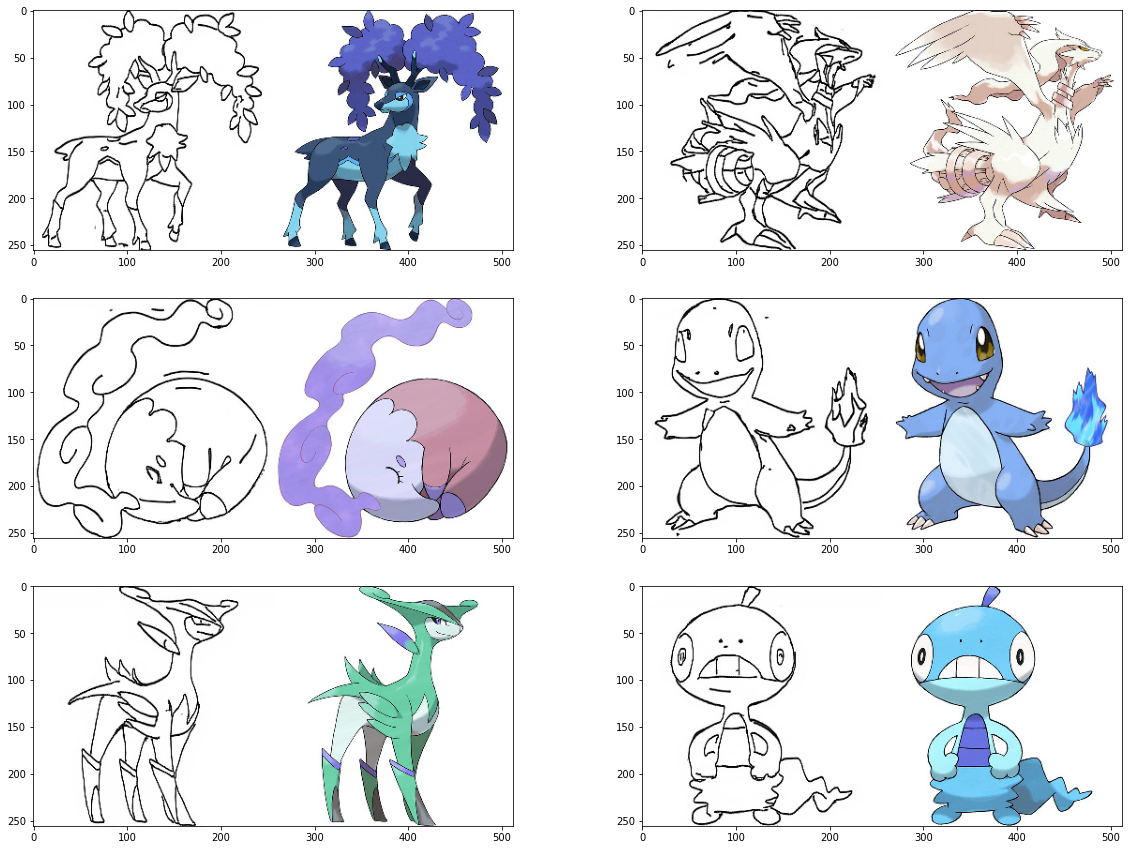

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [19]:
#이미지 크기 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


- 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용하면 됨

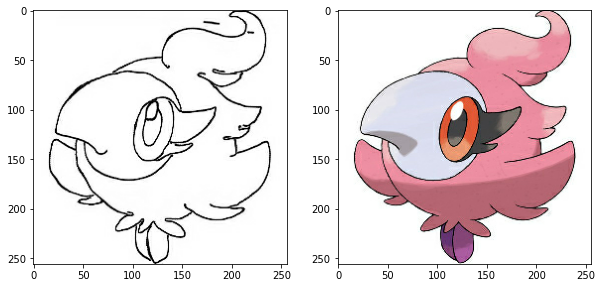

In [7]:
#이미지 2개로 분할
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [8]:
#학습 데이터는 800개 뿐이므로 데이터의 다양성을 높이기 위해 augmentation 방법 적용

from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용

# 스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용하는 함수
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


- apply_augmentation 함수
  - 두 이미지가 채널 축으로 연결되고 이 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼 적용됨.
  - 위의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라내고 이 결과를 50% 확률로 가로로 뒤집음.
  - 위의 결과를 50% 확률로 세로로 뒤집고 다시 50%의 확률로 회전시킴.

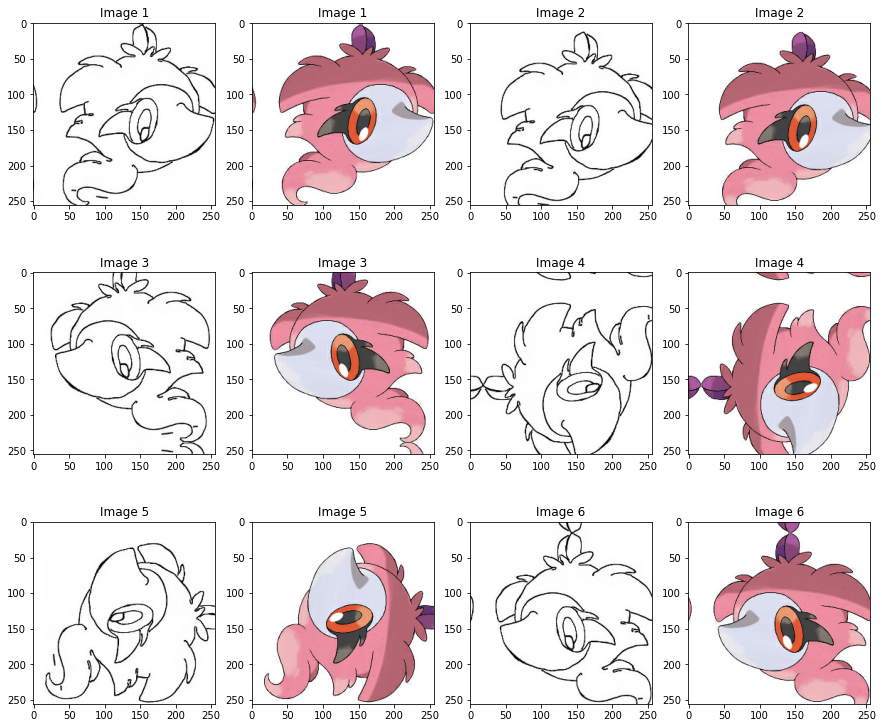

In [9]:
#데이터에 augmentation 적용

plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

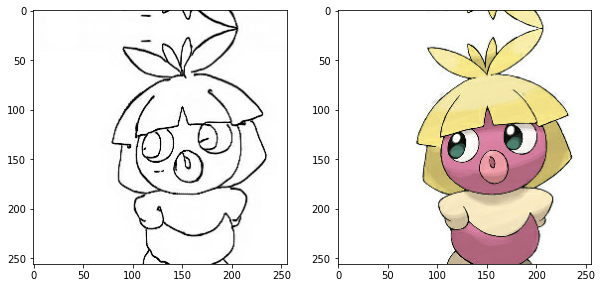

In [10]:
#학습 데이터에 augmentation 적용 후 확인

from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

### - Generator 구성
-  encoder의 "C64"
  - 64개의 4x4 필터에 stride 2를 적용한 Convolution -> 0.2 slope의 LeakyReLU
- decoder의 "CD512"
  - 512개의 4x4 필터에 stride 2를 적용한 (Transposed) Convolution → BatchNorm → 50% Dropout → ReLU

In [11]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


- "Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록을 하나의 레이어로 만듦.

In [12]:
#인코더 생성
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


-  Convolution 레이어에서 필터의 크기(=4) 및 stride(=2)와 LeakyReLU 활성화의 slope coefficient(=0.2)는 모든 곳에서 고정되어 사용됨.
-  이 블록을 여러 번 가져다 사용하면 아래와 같이 쉽게 Encoder를 구성할 수 있음.

In [13]:
#레이어가 제대로 구성되었는지 확인
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

- 블록을 통과할수록 (width, height) 크기는 반씩 줄어들고, 사용된 필터의 수는 최대 512개로 늘어나 최종 (1,1,512)로 알맞은 크기가 출력됨.

In [14]:
#디코더 생성
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [15]:
#레이어가 제대로 구성되었는지 확인
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

- (width, height) 크기가 점점 늘어나고 사용 필터의 수는 점점 줄어들어 최종 (256,256,3) 크기로 출력됨.

In [16]:
#인코더와 디코더 연결해 Generator 구성
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


## Generator 재구성하기
- 이전에 구현했던 것("Encoder-Decoder Generator")들을 조금 수정하여 위 그림의 U-Net 구조("U-Net Generator")를 만들고 실험해 볼 것.

In [17]:
#인코더 및 디코더에 사용되는 기본적인 블록

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [18]:
#U-Net Generator 정의

class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


- Encoder와 Decoder 사이의 skip connection을 위해 features 라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담음.
- 이후 Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과하는데, features 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용됨.
- call() 내에서 features = features[:-1] :
  - Skip connection을 위해 만들어진 features 리스트에는 Encoder 내 각 블록의 출력이 들어있는데, Encoder의 마지막 출력(feature리스트 의 마지막 항목)은 Decoder로 직접 입력되므로 skip connection의 대상이 아님.
- call() 내의 Decoder 연산 부분에서 features[::-1] :
  - Skip connection은 Encoder 내 첫 번째 블록의 출력이 Decoder의 마지막 블록에 연결되고, Encoder 내 두 번째 블록의 출력이 Decoder의 뒤에서 2번째 블록에 연결되는.. 등 대칭을 이룸.
  - features에는 Encoder 블록들의 출력들이 순서대로 쌓여있고, 이를 Decoder에서 차례대로 사용하기 위해서 features의 역순으로 연결.

In [19]:
#U-Net 구조 Generator 내부의 각 출력이 적절한지 확인
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

- U-Net Generator의 Decoder 구조 내 파라미터가 많아졌음.
- 이 부분의 각 convolution 레이어에서 사용된 필터의 수는 두 종류의 Decoder에서 동일하지만, 그 크기가 다름.
- U-Net Generator에서 사용한 skip-connection으로 인해 Decoder의 각 블록에서 입력받는 채널 수가 늘어났고, 이에 따라 블록 내 convolution 레이어에서 사용하는 필터 크기가 커지면서 학습해야 할 파라미터가 늘어난 것.

## Discriminator 구성하기
- 좀 더 사실적인 이미지를 생성하기 위한 Pix2Pix를 완성시키기 위해서는 Discriminator가 필요함.
- Discriminator는 2개 입력(위 그림의 "in", "unknown")을 받아 연결(CONCAT)한 후, ENCODE 라고 쓰인 5개의 블록을 통과함.
- 이 중 마지막 블록을 제외한 4개 블록은 위 논문에서 표기된 "C64-C128-C256-C512"에 해당하며, 마지막은 1(채널)차원 출력을 위한 블록이 추가됨.

In [20]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


- (width, height, channel) = (128, 128, 32) 크기가 입력 시
  - 패딩 레이어 통과 layers.ZeroPadding2D() → (130,130,32)
  - Convolution 레이어 통과 layers.Conv2D(64,4,1,"valid") → (127,127,64)
  - BatchNormalization 레이어 통과 layers.BatchNormalization() → (127,127,64)
  - LeakyReLU 활성화 레이어 통과 layers.LeakyReLU(0.2) → (127,127,64)

In [21]:
#각 출력의 크기 확인
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [22]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        #첫 번째 블록은 단순한 연결(concat)을 수행
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        #Discriminator의 최종 출력은 sigmoid 활성화를 사용
        self.sigmoid = layers.Activation("sigmoid")
        
        ### 이전에 했던 구현 ###
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
        ### 쉽게 코드를 읽기 위해 총 6개의 블록을 따로 만든게 위의 코드 ###
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [23]:
#각 블록의 출력 크기 확인
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

- 두 개의 (256,256,3) 크기 입력으로 최종 (30,30,1) 출력을 만들었음.

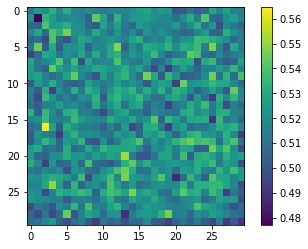

In [24]:
#임의의 (256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력을 시각화
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

- (30,30) 크기를 갖는 결과 이미지의 각 픽셀값은 원래 입력의 (70,70) 패치에 대한 분류 결과임.
- 전체 입력의 크기가 (256,256) 이므로, 각각의 (70,70) 패치는 원래 입력상에서 많이 겹쳐있을 것.
-  각각의 픽셀값은 sigmoid 함수의 결괏값이므로 0~1 사이의 값을 가지며, 진짜 및 가짜 데이터를 판별해내는 데 사용.

## Generator와 Discriminator 학습

In [25]:
#GAN 손실함수와 L1을 추가로 이용
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


- Generator의 손실함수
  - fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값으로 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용.
  -  L1 손실을 계산하기 위해 생성한 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산.
- Discriminator의 손실함수
  - 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값으로 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교함.

In [26]:
#사용할 optimizer 
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [27]:
#하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        #Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        #Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        
        #λ는 학습 과정에서 L1 손실을 얼마나 반영할 것인지를 나타내며 논문에서는 λ=100을 사용
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        #Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [28]:
EPOCHS = 10 

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        #10회 반복마다 손실을 출력
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.0779                     
L1_loss:0.5148                     
Discriminator_loss:1.0412

EPOCH[1] - STEP[20]                     
Generator_loss:0.7682                     
L1_loss:0.3298                     
Discriminator_loss:1.4318

EPOCH[1] - STEP[30]                     
Generator_loss:0.7344                     
L1_loss:0.2916                     
Discriminator_loss:1.2506

EPOCH[1] - STEP[40]                     
Generator_loss:1.3587                     
L1_loss:0.2846                     
Discriminator_loss:0.9341

EPOCH[1] - STEP[50]                     
Generator_loss:1.2863                     
L1_loss:0.2309                     
Discriminator_loss:0.7343

EPOCH[1] - STEP[60]                     
Generator_loss:1.1507                     
L1_loss:0.3113                     
Discriminator_loss:0.7589

EPOCH[1] - STEP[70]                     
Generator_loss:2.1447                     
L1_loss:0.2694                    

EPOCH[3] - STEP[170]                     
Generator_loss:3.5235                     
L1_loss:0.2759                     
Discriminator_loss:1.4560

EPOCH[3] - STEP[180]                     
Generator_loss:2.4660                     
L1_loss:0.2607                     
Discriminator_loss:0.3227

EPOCH[3] - STEP[190]                     
Generator_loss:3.9357                     
L1_loss:0.2845                     
Discriminator_loss:0.1484

EPOCH[3] - STEP[200]                     
Generator_loss:2.7324                     
L1_loss:0.2472                     
Discriminator_loss:0.3653

EPOCH[4] - STEP[10]                     
Generator_loss:0.5062                     
L1_loss:0.2303                     
Discriminator_loss:1.1249

EPOCH[4] - STEP[20]                     
Generator_loss:0.7850                     
L1_loss:0.2897                     
Discriminator_loss:0.8395

EPOCH[4] - STEP[30]                     
Generator_loss:1.5886                     
L1_loss:0.3556                

EPOCH[6] - STEP[130]                     
Generator_loss:3.2534                     
L1_loss:0.2804                     
Discriminator_loss:0.6400

EPOCH[6] - STEP[140]                     
Generator_loss:2.1314                     
L1_loss:0.2344                     
Discriminator_loss:0.3120

EPOCH[6] - STEP[150]                     
Generator_loss:2.9036                     
L1_loss:0.2604                     
Discriminator_loss:0.2916

EPOCH[6] - STEP[160]                     
Generator_loss:0.9839                     
L1_loss:0.2405                     
Discriminator_loss:0.7300

EPOCH[6] - STEP[170]                     
Generator_loss:3.7255                     
L1_loss:0.2688                     
Discriminator_loss:0.6324

EPOCH[6] - STEP[180]                     
Generator_loss:0.6555                     
L1_loss:0.2595                     
Discriminator_loss:1.0261

EPOCH[6] - STEP[190]                     
Generator_loss:0.9024                     
L1_loss:0.2827             

EPOCH[9] - STEP[90]                     
Generator_loss:4.2598                     
L1_loss:0.3956                     
Discriminator_loss:0.6527

EPOCH[9] - STEP[100]                     
Generator_loss:2.7977                     
L1_loss:0.2724                     
Discriminator_loss:0.3272

EPOCH[9] - STEP[110]                     
Generator_loss:0.9649                     
L1_loss:0.2773                     
Discriminator_loss:0.7681

EPOCH[9] - STEP[120]                     
Generator_loss:0.3272                     
L1_loss:0.2138                     
Discriminator_loss:1.5360

EPOCH[9] - STEP[130]                     
Generator_loss:2.5738                     
L1_loss:0.2367                     
Discriminator_loss:1.0107

EPOCH[9] - STEP[140]                     
Generator_loss:0.4871                     
L1_loss:0.2134                     
Discriminator_loss:1.2940

EPOCH[9] - STEP[150]                     
Generator_loss:1.5562                     
L1_loss:0.2771              

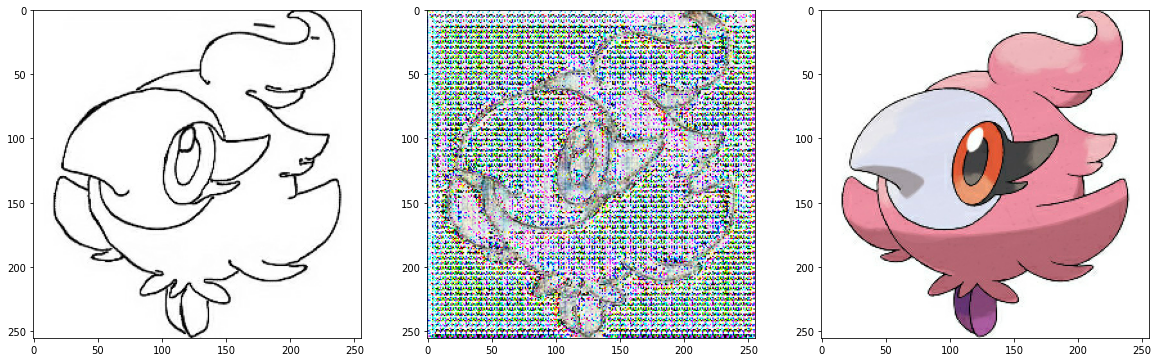

In [29]:
#채색
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))